In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import Video

# --- Parameters ---
liter = 1000
eps = 0.01
nr = 120
nz = 100
rm = 1.0
rp = 0.5
kappa = 1.0
delta = 0.0
b0 = 1.0
q0 = 1.4

# --- Derived ---
r_0 = np.sqrt(rm**2 + rp**2)
aa = rm * rp / r_0
r_max = r_0 - delta * aa
z_max = kappa * aa
E_sol = 2.0 * r_0 * z_max / np.sqrt((r_0**2 - r_max**2)**2 + 4.0 * aa**2 * r_0**2)
d_sol = 1.0 - 2.0 * r_0**2 * (r_0**2 - r_max**2) / ((r_0**2 - r_max**2)**2 + 4.0 * aa**2 * r_0**2)
psi_s = aa**2 * E_sol * b0 / (2.0 * q0)

# --- Grad–Shafranov solver ---
def solve_grad_shafranov(flag_solver="cg"):
    assert flag_solver in ["cg", "sd", "jacobi", "gauss_seidel", "sor"], f"Unknown solver: {flag_solver}"

    # --- Grid ---
    r_left = r_0 * np.sqrt(1.0 - 2.0 * aa / r_0)
    r_right = r_0 * np.sqrt(1.0 + 2.0 * aa / r_0)
    dr = (r_right - r_left) / (nr - 1)
    z_top = z_max
    z_bottom = -z_max
    dz = (z_top - z_bottom) / (nz - 1)
    # nr+2 点、nz+2 点。前後１点ずつゴーストグリッド。
    rr = np.array([r_left + dr * (i - 1) for i in range(nr + 2)])
    zz = np.array([dz * (j - nz // 2 - 1) for j in range(nz + 2)])
    RR, ZZ = np.meshgrid(rr, zz, indexing='xy')

    # --- Mask ---
    def inside_mask(rr, zz):
        t1 = ((1 - d_sol) * rr**2 + d_sol * r_0**2) * zz**2 / E_sol**2
        t2 = 0.25 * (rr**2 - r_0**2)**2
        return t1 + t2 < aa**2 * r_0**2

    mask = inside_mask(RR, ZZ)

    # --- RHS and Initial ---
    rhs = np.zeros_like(RR)
    rhs[mask] = (
        2.0 * RR[mask]**2 * psi_s / (aa**2 * r_0**2) * (1.0 + (1.0 - d_sol) / E_sol**2)
        + 2.0 * d_sol * psi_s / (aa**2 * E_sol**2)
    )
    psi = np.zeros_like(rhs)

    # --- Operator ---
    def apply_operator(phi):
        out = np.zeros_like(phi)
        out[1:-1, 1:-1] = (
            (1.0 / dr**2 - 0.5 / (dr * RR[1:-1, 1:-1])) * phi[2:, 1:-1] +
            (1.0 / dr**2 + 0.5 / (dr * RR[1:-1, 1:-1])) * phi[:-2, 1:-1] +
            1.0 / dz**2 * (phi[1:-1, 2:] + phi[1:-1, :-2]) -
            2.0 * (1.0 / dr**2 + 1.0 / dz**2) * phi[1:-1, 1:-1]
        )
        return out * mask

    # --- Solver steps ---
    def sd_step(psi, r, p, rs_old):
        Ar = apply_operator(r)
        alpha = np.sum(r * r) / np.sum(r * Ar)
        psi += alpha * r
        r_new = r - alpha * Ar
        return psi, r_new, r_new, np.sum(r_new * r_new)

    def cg_step(psi, r, p, rs_old):
        Ap = apply_operator(p)
        alpha = rs_old / np.sum(p * Ap)
        psi += alpha * p
        r_new = r - alpha * Ap
        rs_new = np.sum(r_new * r_new)
        beta = rs_new / rs_old
        p_new = r_new + beta * p
        return psi, r_new, p_new, rs_new

    def jacobi_step(psi, _, __, ___):
        psi_new = psi.copy()
        coef1 = dz**2 / (2 * (dr**2 + dz**2))
        coef2 = dr**2 / (2 * (dr**2 + dz**2))
        coef3 = dr**2 * dz**2 / (2 * (dr**2 + dz**2))
        for iz in range(1, nz):
            for ir in range(1, nr):
                if mask[iz, ir]:
                    psi_new[iz, ir] = coef1 * (1 - 0.5 * dr / RR[iz, ir]) * psi[iz, ir + 1] + \
                                       coef1 * (1 + 0.5 * dr / RR[iz, ir]) * psi[iz, ir - 1] + \
                                       coef2 * (psi[iz + 1, ir] + psi[iz - 1, ir]) - \
                                       coef3 * rhs[iz, ir]
        r_new = rhs - apply_operator(psi_new)
        return psi_new, r_new, None, np.sum(r_new * r_new)

    def gauss_seidel_step(psi, _, __, ___):
        coef1 = dz**2 / (2 * (dr**2 + dz**2))
        coef2 = dr**2 / (2 * (dr**2 + dz**2))
        coef3 = dr**2 * dz**2 / (2 * (dr**2 + dz**2))
        for iz in range(1, nz):
            for ir in range(1, nr):
                if mask[iz, ir]:
                    psi[iz, ir] = coef1 * (1 - 0.5 * dr / RR[iz, ir]) * psi[iz, ir + 1] + \
                                  coef1 * (1 + 0.5 * dr / RR[iz, ir]) * psi[iz, ir - 1] + \
                                  coef2 * (psi[iz + 1, ir] + psi[iz - 1, ir]) - \
                                  coef3 * rhs[iz, ir]
        r_new = rhs - apply_operator(psi)
        return psi, r_new, None, np.sum(r_new * r_new)

    def sor_step(psi, _, __, ___):
        coef1 = dz**2 / (2 * (dr**2 + dz**2))
        coef2 = dr**2 / (2 * (dr**2 + dz**2))
        coef3 = dr**2 * dz**2 / (2 * (dr**2 + dz**2))
        alpha = 1.82
        for iz in range(1, nz):
            for ir in range(1, nr):
                if mask[iz, ir]:
                    update_val = coef1 * (1 - 0.5 * dr / RR[iz, ir]) * psi[iz, ir + 1] + \
                                 coef1 * (1 + 0.5 * dr / RR[iz, ir]) * psi[iz, ir - 1] + \
                                 coef2 * (psi[iz + 1, ir] + psi[iz - 1, ir]) - \
                                 coef3 * rhs[iz, ir]
                    psi[iz, ir] = (1 - alpha) * psi[iz, ir] + alpha * update_val
        r_new = rhs - apply_operator(psi)
        return psi, r_new, None, np.sum(r_new * r_new)

    solver_dict = {
        "cg": cg_step,
        "sd": sd_step,
        "jacobi": jacobi_step,
        "gauss_seidel": gauss_seidel_step,
        "sor": sor_step
    }
    iterative_solver = solver_dict[flag_solver]

    # --- Iterative loop ---
    r = rhs - apply_operator(psi)
    p = r.copy()
    rs_old = np.sum(r * r)
    errors = []
    psi_all = [psi.copy()]

    for i in range(liter):
        psi, r, p, rs_new = iterative_solver(psi, r, p, rs_old)
        rel_error = np.sqrt(rs_new) / np.sqrt(np.sum(rhs**2))
        errors.append(rel_error)
        psi_all.append(psi.copy())
        if rel_error < eps:
            print(f"Converged at iter = {i}, error = {rel_error}")
            break
        rs_old = rs_new
    else:
        print(f"Did not converge within {liter} iterations. Final error = {rel_error}")

    return psi_all, errors, RR, ZZ

def compute_boundary_curve(num_points=500):
    """
    Return rr_curve, zz_curve as parametric boundary based on Solov'ev parameters.
    """
    t = np.linspace(0, 2 * np.pi, num_points)
    eps_val = aa / r_0
    sqrt_p = np.sqrt(psi_s / psi_s)  # =1.0
    rr_curve = r_0 * np.sqrt(1.0 + 2.0 * eps_val * sqrt_p * np.cos(t))
    zz_curve = (aa * E_sol * sqrt_p * np.sin(t)) / np.sqrt(1.0 + 2.0 * eps_val * sqrt_p * (1.0 - d_sol) * np.cos(t))
    return rr_curve, zz_curve

def solovev_solution(rr, zz):
    """
    Return Solov'ev analytic solution components: psi, pressure, B^2, rhs.
    All outputs are masked: outside the plasma domain, values are zero.
    """
    term = ((1 - d_sol) * rr**2 + d_sol * r_0**2) * zz**2 / E_sol**2 + 0.25 * (rr**2 - r_0**2)**2
    mask = term < aa**2 * r_0**2

    psi_sol = np.zeros_like(rr)
    pres_sol = np.zeros_like(rr)
    T2_sol = np.zeros_like(rr)
    rhs_sol = np.zeros_like(rr)

    psi_tmp = psi_s / (aa**2 * r_0**2) * (
        ((1 - d_sol) * rr[mask]**2 + d_sol * r_0**2) * zz[mask]**2 / E_sol**2 +
        0.25 * (rr[mask]**2 - r_0**2)**2
    ) - psi_s

    psi_sol[mask] = psi_tmp
    pres_sol[mask] = 4.0 * psi_s / (aa**2 * r_0**2) * (1 + (1 - d_sol) / E_sol**2) * (-psi_tmp)
    T2_sol[mask] = (r_0 * b0)**2 - 4.0 * d_sol * psi_s * (psi_tmp + psi_s) / (aa**2 * E_sol**2)
    rhs_sol[mask] = (
        2.0 * rr[mask]**2 * psi_s / (aa**2 * r_0**2) * (1 + (1 - d_sol) / E_sol**2) +
        2.0 * d_sol * psi_s / (aa**2 * E_sol**2)
    )
    return psi_sol, pres_sol, T2_sol, rhs_sol, mask

# --- Run iterative solvers ---
psi_all, errors, RR, ZZ = solve_grad_shafranov(flag_solver="cg")
psi = psi_all[-1]


# --- Verification against analytic solution ---
rr_curve, zz_curve = compute_boundary_curve()
psi_sol, pres_sol, T2_sol, rhs_sol, mask = solovev_solution(RR, ZZ)

Converged at iter = 184, error = 0.009926214758288338


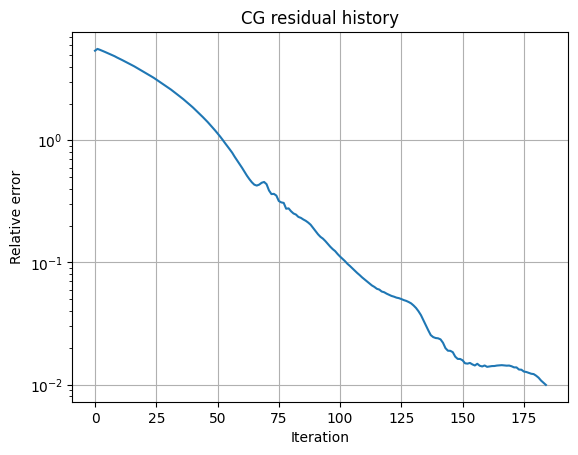

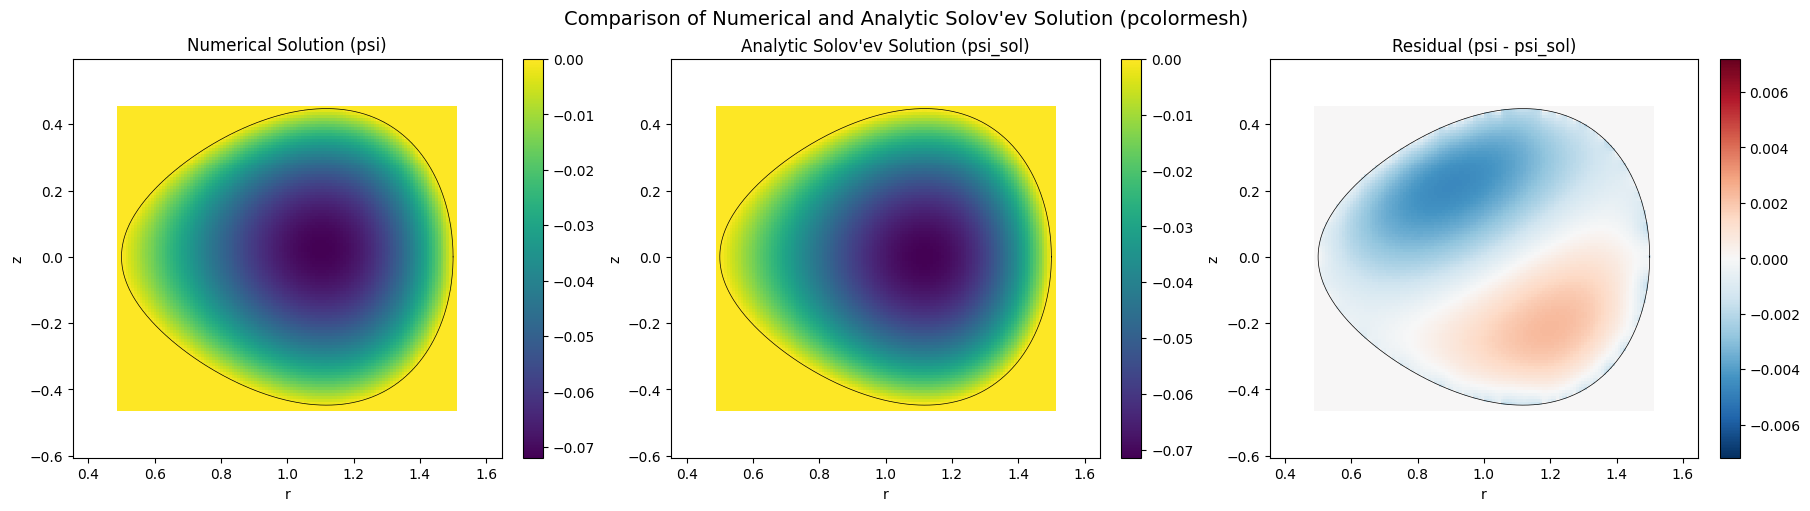

In [2]:
# --- Plot convergence history ---
plt.figure()
plt.semilogy(errors)
plt.xlabel('Iteration')
plt.ylabel('Relative error')
plt.title('CG residual history')
plt.grid(True)
plt.show()

# --- Plot with pcolormesh instead of contourf ---
vmax = np.max(np.abs(psi))
res_vmax = np.max(np.abs(psi - psi_sol))
res_vmax = 0.1 * vmax
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
pc1 = axes[0].pcolormesh(RR, ZZ, psi, shading='auto')
axes[0].plot(rr_curve, zz_curve, color='black', linewidth=0.5)
axes[0].set_title('Numerical Solution (psi)')
fig.colorbar(pc1, ax=axes[0])
pc2 = axes[1].pcolormesh(RR, ZZ, psi_sol, shading='auto')
axes[1].plot(rr_curve, zz_curve, color='black', linewidth=0.5)
axes[1].set_title("Analytic Solov'ev Solution (psi_sol)")
fig.colorbar(pc2, ax=axes[1])
pc3 = axes[2].pcolormesh(RR, ZZ, psi - psi_sol, cmap='RdBu_r',
                         shading='auto', vmin=-res_vmax, vmax=+res_vmax)
axes[2].plot(rr_curve, zz_curve, color='black', linewidth=0.5)
axes[2].set_title('Residual (psi - psi_sol)')
fig.colorbar(pc3, ax=axes[2])
for ax in axes:
    ax.set_xlabel('r')
    ax.set_ylabel('z')
    ax.axis('equal')
plt.suptitle("Comparison of Numerical and Analytic Solov'ev Solution (pcolormesh)", fontsize=14)
plt.show()

In [ ]:
# --- Animation for convergence ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

wire = None  # for clearing
zmin = np.min(psi_all[-1])
zmax = np.max(psi_all[-1])
def update(frame):
    global wire
    ax.clear()
    ax.set_title(f"Iteration {frame}")
    ax.set_xlabel("r")
    ax.set_ylabel("z")
    ax.set_zlabel("psi")
    ax.set_xlim(RR.min(), RR.max())
    ax.set_ylim(ZZ.min(), ZZ.max())
    ax.set_zlim(zmin,zmax)
    wire = ax.plot_surface(RR, ZZ, psi_all[frame], cmap=cm.viridis, edgecolor='k', linewidth=0.3, antialiased=True)
    return wire,

ani = FuncAnimation(fig, update, frames=range(0, len(psi_all), 10), interval=100, blit=False)
ani.save("gs_wireframe_animation.mp4", writer="ffmpeg", fps=10)
plt.close(fig)

# --- Optionally embed in notebook ---
Video("gs_wireframe_animation.mp4", embed=True)